In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import mean_squared_error as mse
import time 

In [7]:
def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal 's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        r : received signal vector (r=s+n)
"""
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if np.isrealobj(s):# check if input is real/complex object type
        n = np.sqrt(N0/2)*np.random.standard_normal(s.shape) # computed noise
    else:
        n = np.sqrt(N0/2)*(np.random.standard_normal(s.shape)+1j*np.random.standard_normal(s.shape))
    r = s + n # received signal
    return r

In [8]:
import numpy as np

def rqnn(X, y, delta_t, delta_x, m=0.1, gamma=2, zeta=83, beta=0.8):
    y = np.array(y)
    time_steps = y.shape[0]
    N = X.shape[0]

    t = np.arange(time_steps) * delta_t
    psi = np.zeros((N, time_steps), dtype=np.complex128)
    psi[:, 0] = np.exp(-np.square(X) / 2) / np.sqrt(2 * np.pi)
    y_hat = np.zeros(time_steps)

    K = 0.5 * (2 * np.random.rand(N) - 1)
    v = np.zeros((N, time_steps))

    for i in range(time_steps - 1):
        for _ in range(gamma):
            inte = np.dot(X, np.square(np.abs(psi[:, i])) * delta_x)
            y_hat[i + 1] = inte
            nu = y[i] - y_hat[i]

            v[:, i] = -(zeta * nu * K)
            psi[1:N - 1, i + 1] = (
                psi[1:N - 1, i] - 1j * delta_t * v[1:N - 1, i] * psi[1:N - 1, i]
                + 1j * delta_t * (psi[2:N, i] - 2 * psi[1:N - 1, i] + psi[0:N - 2, i])
                / (2 * m * delta_x * delta_x)
            )
            psi[0, i + 1] = (
                psi[0, i] - 1j * delta_t * v[0, i] * psi[0, i]
                + 1j * delta_t * (psi[1, i] - 2 * psi[0, i] + psi[N - 1, i])
                / (2 * m * delta_x * delta_x)
            )
            psi[N - 1, i + 1] = (
                psi[N - 1, i] - 1j * delta_t * v[N - 1, i] * psi[N - 1, i]
                + 1j * delta_t * (psi[0, i] - 2 * psi[N - 1, i] + psi[N - 2, i])
                / (2 * m * delta_x * delta_x)
            )

            psi[:, i + 1] /= np.linalg.norm(psi[:, i + 1])
            K[1:N] += beta * nu * np.square(np.abs(psi[1:N, i + 1]))
    
        #plot
#         plt.figure(figsize=(8, 6), dpi= 100)

#         #with plt.ion():

#         plot1, = plt.plot(t,y,'r',linewidth = 0.7)
#         plt.ylim(-5, 5)
#         plot2, = plt.plot(t,y_hat,linewidth = 0.7);
#         plt.ylim(-5, 5)
#         plt.legend([plot1,plot2],['DC Signal(6db SNR)','Estimated Signal'])
#         display.clear_output(wait=True)
#         plt.pause(0.0001)

    return y_hat, psi, K


Time Elapsed: 0.9731252193450928


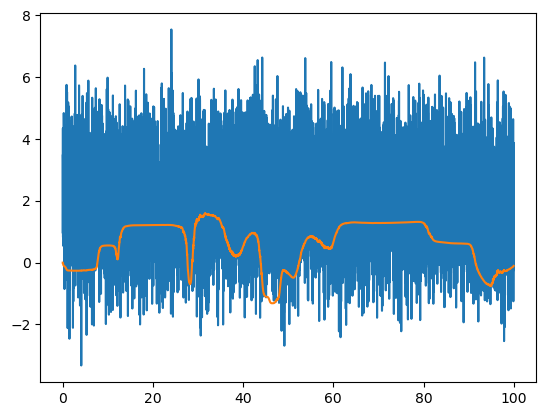

In [21]:
y = awgn(np.zeros(10000)+2, 0, L=1)
t = np.array( [i*0.01 for i in range(10000)] )
X = np.arange(-20,20,0.1)
start_time = time.time()
y_hat, psi, K = rqnn(X,y,0.01,0.1, m=0.1, zeta=320, beta=0.0008)
end_time = time.time()
print("Time Elapsed:", end_time - start_time)
plt.plot(t, y)
plt.plot(t, y_hat)
